# Homework 2

## Imports 


In [166]:
# Sklearn Imports
import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
# Other Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.io.arff import loadarff
from scipy import stats

## Loading Data Set

In [167]:
IMAGES_DIR = Path('images')
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR = Path('data')
DATA_DIR.mkdir(parents=True, exist_ok=True)
DATA_FILE = 'column_diagnosis.arff'
DATA_PATH = DATA_DIR / DATA_FILE
data = loadarff(DATA_PATH)
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')
# Show the first 5 rows
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


## 10-fold cross validation with suffling 


In [168]:
# Split into features and labels 
X = df.drop('class', axis=1)
y = df['class']

In [169]:
# Stratified 10 fold cross validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

# kNN Classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Naive Bayes Classifier
nb = GaussianNB()

# 10-fold startified cross validation with shuffle
knn_score = cross_val_score(knn,
                            X,
                            y,
                            cv=cv,
                            scoring='accuracy')

nb_score = cross_val_score(nb,
                            X,
                            y,
                            cv=cv,
                            scoring='accuracy')



## Box Plots for Fold Accuracy of Each Classifier

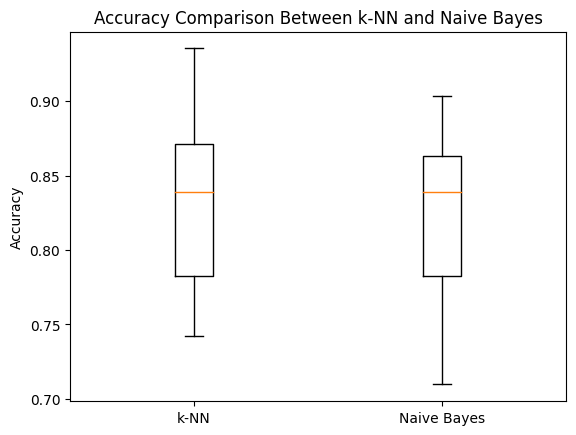

In [170]:
# Create boxplots for the accuracies of both classifiers
plt.boxplot([knn_score, nb_score], labels=['k-NN', 'Naive Bayes'])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Between k-NN and Naive Bayes')
plt.show()

In [171]:
# Perform a two-sample t-test to compare the means
t_stat, p_value = stats.ttest_rel(knn_score, nb_score, alternative='greater')
print(f"t-statistic: {str(t_stat)}")
print(f"p-value: {str(p_value)}")

# Determine if the null hypothesis can be rejected (p < 0.05)
alpha = 0.05
if p_value < alpha:
    print("Null hypothesis rejected: \nkNN is statistically superior to Naive Bayes.")
else:
    print("Null hypothesis not rejected: \nNo significant difference between kNN and Naive Bayes.")

t-statistic: 0.9214426752509264
p-value: 0.19042809062064092
Null hypothesis not rejected: 
No significant difference between kNN and Naive Bayes.


# Question 2


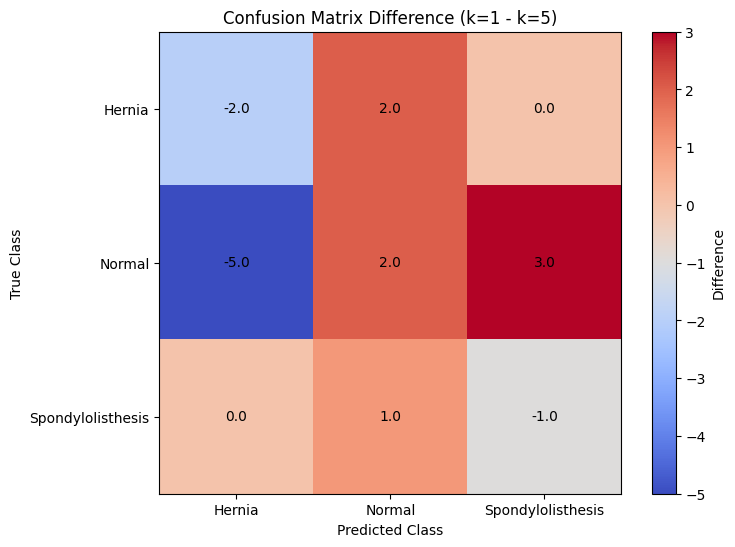

In [172]:
# Create k-NN classifiers with k=1 and k=5
knn_k1 = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')
knn_k5 = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')

# Create a confusion matrix for each classifier
confusion_matrix_k1 = np.zeros((3, 3))
confusion_matrix_k5 = np.zeros((3, 3))

for train_index, test_index in cv.split(X, y):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit both models to the dataset
    knn_k1.fit(X_train, y_train)
    knn_k5.fit(X_train, y_train)

    # Make predictions using both models
    predictions_k1 = knn_k1.predict(X_test)
    predictions_k5 = knn_k5.predict(X_test)

    # Add the confusion matrices to the cumulative confusion matrices
    confusion_matrix_k1 += confusion_matrix(y_test, predictions_k1)
    confusion_matrix_k5 += confusion_matrix(y_test, predictions_k5)

# Plot the differences between the cumulative confusion matrices
# Get the class names
class_names = np.unique(y)

# Calculate the difference between the cumulative confusion matrices
confusion_matrix_difference = confusion_matrix_k1 - confusion_matrix_k5

# Plot the differences between the cumulative confusion matrices
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix_difference, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Difference')
plt.title('Confusion Matrix Difference (k=1 - k=5)')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')

# Loop over the cells and add the values to the plot
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_matrix_difference[i, j]), horizontalalignment='center', verticalalignment='center')
    
plt.show()

### Comment: 
As seen by the difference confusion cummulative matrix above, the classifiers do not have significant differences, since the highest difference between them is 5. As for some entraces of the matrix, one can say both classifiers have the same performance, since the difference between them is 0. For negative values on the diagonal, it means that the classifier knn5 has a better performance than the classifier knn1, and for positive values, the opposite. As for the rest of the matrix, one can see more positive values than negative, which means that the classifier knn5 has a better performance and gets less confused than the classifier knn1.

# Question 3

There are some problems that Naive Bayes may encounter. The tree main problems we can think of are:
- Independence Assumption
- Continuous Features
- Imbalanced Classes

### Independence Assumption
Naive Bayes assumes that features are conditionally independent given the class label. In other words, it assumes that there are no correlations between the features. However, in real-world datasets like medical diagnoses, features may be correlated. For example, certain symptoms or medical test results might be related. If there are strong correlations between features, Naive Bayes may not capture these relationships accurately, leading to suboptimal performance.

### Continuous Features
If the dataset contains continuous or numerical features, Naive Bayes relies on assuming that the data follows a specific probability distribution (e.g., Gaussian for Gaussian Naive Bayes). If the data distribution significantly deviates from this assumption, the model's performance can degrade. Medical datasets often contain a mix of continuous and categorical features, and handling continuous data can be a challenge for Naive Bayes.

### Imbalanced Classes
If the dataset has imbalanced class distributions, where one class significantly outnumbers the others, Naive Bayes can be biased towards the majority class. This is because the class prior probabilities heavily influence the classification decision. In medical datasets, it's common to have imbalanced class distributions, such as a rare disease. Naive Bayes may struggle to correctly classify the minority class due to the bias.

To address if those problems exist in our dataset, we can do the following:
- Check if there are correlations between features
- Check if the data follows the assumed probability distribution
- Check if the class distributions are balanced

We do that in the following code:

## Independence Assumption

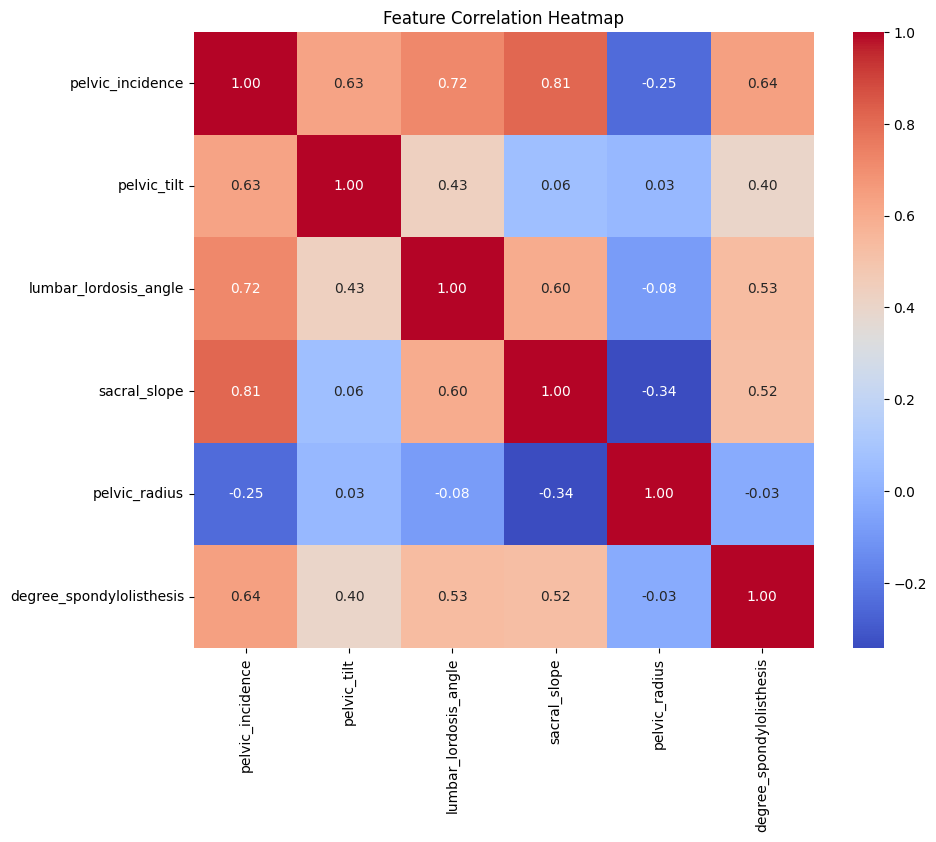

In [173]:
# Independence Assumption
# Calculate pairwise feature correlations
correlation_matrix = X.corr()

# Visualize feature correlations using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


Comment:
- As one can see in the correlation matrix, there are some features that are correlated. For example, the features "sacral_slope" and "pelvic_incidence" are correlated with a correlation coefficient of 0.81, which is considered as a strong correlation. This means that Naive Bayes may not be the best choice for this dataset, since it assumes that features are independent.

## Continuous Features

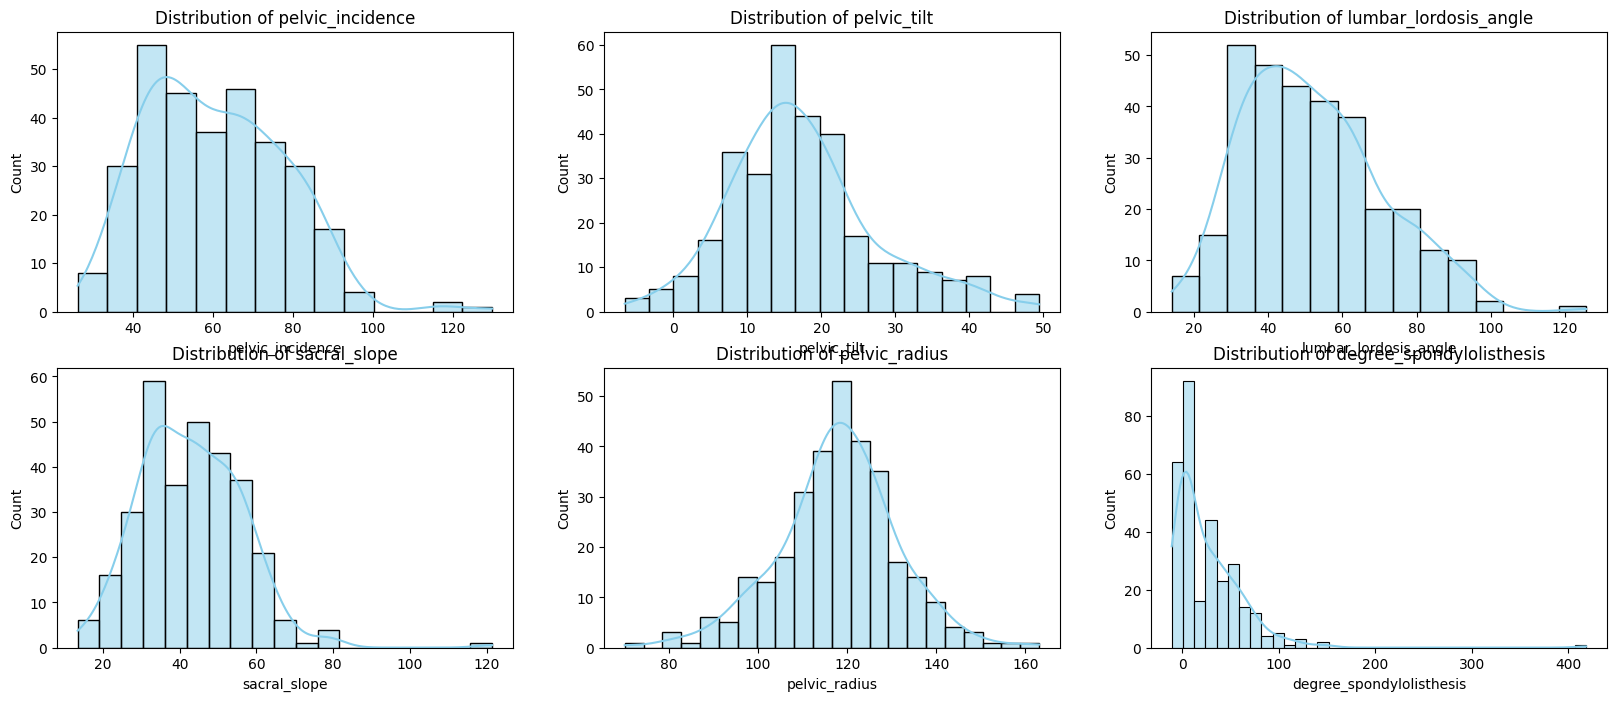

In [174]:

# Continuous Features
# Identify continuous features (assuming all non-integer features are continuous)
continuous_features = [col for col in X.columns if X[col].dtype != 'int64']

# Plot histograms for continuous features
num_cols = 3
num_rows = int(np.ceil(len(continuous_features) / num_cols))
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))

for i, feature in enumerate(continuous_features):
    row = i // num_cols
    col = i % num_cols
    sns.histplot(data=X, x=feature, kde=True, color='skyblue', ax=axs[row][col])
    axs[row][col].set_title(f'Distribution of {feature}')

plt.show()


Comment: 
- As one can see in the above plot, almost all features resemble a Gaussian distribution. However, there are some features that do not follow a Gaussian distribution. For example, the Degree Spondylolisthesis is close to the origin, more like a Gamma distribution. This may cause problems for Naive Bayes, since it assumes a Gaussian distribution. To resolve this possible issue, one can try to preprocess the data in order to make it more Gaussian-like.

## Imbalanced Classes

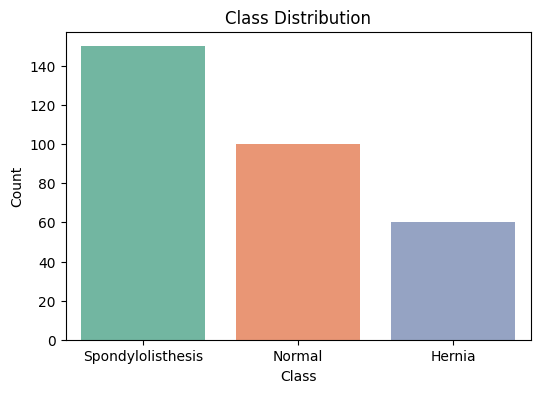

Class Frequencies:
class
Spondylolisthesis    150
Normal               100
Hernia                60
Name: count, dtype: int64


In [175]:
# Imbalanced Classes
# Count class frequencies
class_counts = y.value_counts()

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set2")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Output class frequencies
print("Class Frequencies:")
print(class_counts)

Comment:
- As one can see in the above plot, the class distributions do not seem to be balanced. The Spondylolisthesis class significantly outnumbers the other two classes, making it more than the double of the Hernia class and 50% more than the Normal Class. This may cause problems for Naive Bayes, since it can be biased towards the majority class. To resolve this possible issue, one can try to balance the class distributions by either undersampling the majority class or oversampling the minority classes.